In [315]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pprint
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [316]:
df = pd.read_csv('../../dataset_samples/daod_mc16_13TeV_sequences.csv')

In [317]:
df = df.reindex(np.random.permutation(df.index))

In [318]:
df['n_tasks'] = df['n_tasks'].apply(lambda x: [int(item) for item in x[1:-1].split(',')])

In [319]:
initlal_sequences = list(df['n_tasks'].values)

In [398]:
N = 30

In [381]:
# make supervised data sample
# - dataset sequence starts from the week when the dataset was accessed for the first time
# and finishes in N weeks
# - label for this dataset is calculated from (N+10)th week
new_sequences = []
labels = []
for sequence in initlal_sequences:
    number_of_accesses = sum(sequence)
    # skip not popular datasets
    if number_of_accesses > 30:
        # find first element > 0 in the sequence
        new_index = [index for index,item in enumerate(sequence) if item>0][0]
        if len(sequence[new_index:]) > N+1:
            new_sequence = sequence[new_index:new_index+N]
            new_sequences.append(new_sequence)
            labels.append(1 if sequence[new_index+N]>0 else 0)

In [382]:
new_sequences = np.array(new_sequences)

In [383]:
print(new_sequences)

[[1 0 4 ... 2 2 1]
 [7 2 2 ... 0 0 0]
 [4 1 8 ... 0 0 0]
 ...
 [2 5 4 ... 1 4 0]
 [1 0 0 ... 1 3 2]
 [1 1 0 ... 0 0 1]]


In [384]:
Y = np.array(labels)

In [385]:
n_features = 1
X = new_sequences.reshape((new_sequences.shape[0], new_sequences.shape[1], n_features))
print(X[:2])

[[[ 1]
  [ 0]
  [ 4]
  [ 1]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 1]
  [ 2]
  [ 2]
  [ 1]
  [ 0]
  [ 1]
  [ 1]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 3]
  [ 2]
  [ 0]
  [ 0]
  [ 0]
  [ 7]
  [ 0]
  [ 0]
  [ 2]
  [ 2]
  [ 1]]

 [[ 7]
  [ 2]
  [ 2]
  [ 0]
  [ 8]
  [ 0]
  [ 8]
  [ 1]
  [ 3]
  [19]
  [ 0]
  [ 1]
  [ 0]
  [ 1]
  [ 2]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 0]
  [ 0]]]


In [386]:
X.shape

(9881, 30, 1)

In [387]:
Ntest = 1500
Xtrain = X[:-Ntest]
Xtest = X[-Ntest:]
Ytrain = Y[:-Ntest]
Ytest = Y[-Ntest:]

In [388]:
Ytrain

array([1, 0, 0, ..., 1, 1, 1])

In [389]:
# optimal number of units
# n_units = Xtrain.shape[0]/(2*())

In [399]:
T = N
D = 1
K = 2

In [400]:
i = Input(shape=(T,D))
x = LSTM(24, return_sequences=True)(i)
x = LSTM(24, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [401]:
# i = Input(shape=(30,1))
# x = LSTM(32, return_sequences=True)(i)
# x = GlobalMaxPooling1D()(x)
# x = Dense(2)(x)
# model = Model(i,x)

In [402]:
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 30, 1)]           0         
                                                                 
 lstm_19 (LSTM)              (None, 30, 24)            2496      
                                                                 
 lstm_20 (LSTM)              (None, 30, 24)            4704      
                                                                 
 global_max_pooling1d_17 (Gl  (None, 24)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_18 (Dense)            (None, 2)                 50        
                                                                 
Total params: 7,250
Trainable params: 7,250
Non-trainable params: 0
________________________________________________________

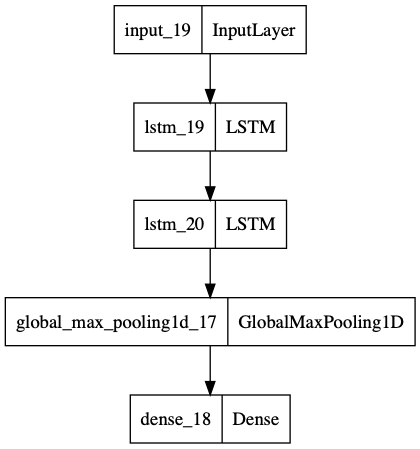

In [403]:
tf.keras.utils.plot_model(model)

In [404]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True
)

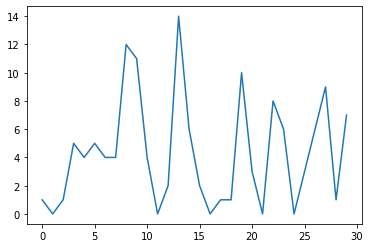

In [405]:
plt.plot(Xtrain[2000, :, :]);

In [406]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)
# The from_logits=True attribute inform the loss function that the output values generated by the model are not normalized, a.k.a. logits. In other words, the softmax function has not been applied on them to produce a probability distribution. The softmax function would be automatically applied on the output values by the loss function. Therefore, this does not make a difference with the scenario when you use from_logits=False (default) and a softmax activation function on last layer; however, in some cases, this might help with numerical stability during training of the model.

In [407]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=50,
    callbacks=[check_point],
    validation_data=(Xtest, Ytest)
)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
259/262 [============================>.] - ETA: 0s - loss: 0.5835 - accuracy: 0.6675WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fd65991f3b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

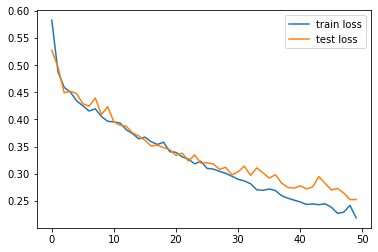

In [408]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

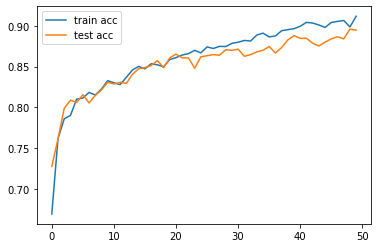

In [409]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [410]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [411]:
# make predictions
Ptest = best_model.predict(Xtest)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
47/47 [==============================] - 1s 4ms/step


In [412]:
Ptest

array([[ 2.9418242 , -3.3591683 ],
       [ 1.3524264 , -2.091523  ],
       [ 2.3247604 , -3.096203  ],
       ...,
       [-0.93482924, -0.08852847],
       [-1.9133828 ,  0.81926167],
       [ 0.67106783, -0.57344556]], dtype=float32)

In [413]:
np.argmax(Ptest, axis=1)

array([0, 0, 0, ..., 1, 1, 0])

In [414]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.896

In [415]:
Ytest

array([0, 0, 0, ..., 1, 1, 0])

In [416]:
np.argmax(Ptest, axis=1)

array([0, 0, 0, ..., 1, 1, 0])

In [417]:
# Print results:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(f'Accuracy: {accuracy_score(Ytest, np.argmax(Ptest, axis=1))}')
print('Confusion Matrix')
print(confusion_matrix(Ytest, np.argmax(Ptest, axis=1)))
print('Classification Report')
print(classification_report(Ytest, np.argmax(Ptest, axis=1)))

Accuracy: 0.896
Confusion Matrix
[[735  96]
 [ 60 609]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       831
           1       0.86      0.91      0.89       669

    accuracy                           0.90      1500
   macro avg       0.89      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



In [418]:
# sequences for evaluation (from the third not 0 element)
eval_sequences = []
eval_labels = []
for sequence in initlal_sequences:
    number_of_accesses = sum(sequence)
    # skip not popular datasets
    if number_of_accesses > 30:
        try:
            new_index = [index for index,item in enumerate(sequence) if item > 0][1]
            if len(sequence[new_index:]) > N+1:
                new_sequence = sequence[new_index:new_index+N]
                eval_sequences.append(new_sequence)
                eval_labels.append(1 if sequence[new_index+N]>0 else 0)
        except:
            continue

In [419]:
eval_sequences = np.array(eval_sequences)
eval_sequences = eval_sequences.reshape((eval_sequences.shape[0], eval_sequences.shape[1], 1))

In [420]:
print(eval_sequences)

[[[4]
  [1]
  [0]
  ...
  [1]
  [1]
  [0]]

 [[2]
  [2]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[1]
  [8]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[5]
  [4]
  [1]
  ...
  [4]
  [0]
  [2]]

 [[2]
  [1]
  [0]
  ...
  [4]
  [0]
  [4]]

 [[1]
  [0]
  [0]
  ...
  [0]
  [1]
  [0]]]


In [421]:
eval_labels = np.array(eval_labels)

In [422]:
pred_y_eval = best_model.predict(eval_sequences)

309/309 [==============================] - 1s 4ms/step


In [423]:
# evaluate
np.mean(np.argmax(pred_y_eval, axis=1) == eval_labels)

0.7271531221536282

In [424]:
print(f'Accuracy: {accuracy_score(eval_labels, np.argmax(pred_y_eval, axis=1))}')
print('Confusion Matrix')
print(confusion_matrix(eval_labels, np.argmax(pred_y_eval, axis=1)))
print('Classification Report')
print(classification_report(eval_labels, np.argmax(pred_y_eval, axis=1)))

Accuracy: 0.7271531221536282
Confusion Matrix
[[4140 1456]
 [1240 3045]]
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      5596
           1       0.68      0.71      0.69      4285

    accuracy                           0.73      9881
   macro avg       0.72      0.73      0.72      9881
weighted avg       0.73      0.73      0.73      9881

